In [70]:
from __future__ import annotations
import numpy as np
import pandas as pd
import random

from matplotlib import pyplot as plt

In [81]:
class Node:
    def __init__(self, id: int, infected: bool = False):
        self.id = id
        self.infected = infected
        self.neighbors = []

    def add_neighbor(self, neighbor: Node):
        self.neighbors.append(neighbor)
    
    def __repr__(self):
        return f"Node {self.id} - infected: {self.infected} " + str([n.id for n in self.neighbors])

class Edge:
    def __init__(self, start_node, end_node):
        self.start_node = start_node
        self.end_node = end_node

class Graph:
    def __init__(self, size):
        self.size = size
        self.nodes = [Node(i, False) for i in range(self.size)]
        self.edges = []

    def tick(self):
        pass
                    

    def create_edge(self, node_id1, node_id2):
        assert(node_id1 < self.size and node_id2 < self.size)
        if not node_id1 in self.nodes[node_id2].neighbors:
            self.edges.append(Edge(self.nodes[node_id1], self.nodes[node_id2]))
            self.nodes[node_id1].add_neighbor(self.nodes[node_id2])
            self.nodes[node_id2].add_neighbor(self.nodes[node_id1])
    
    def __repr__(self):
        res = "Graph: "
        for e in self.edges:
            res += f"{e.start_node.id} - {e.end_node.id} \n"
        return res

class SIModel(Graph):
    def __init__(self, size, infection_prob):
        super().__init__(size)
        self.infection_prob = infection_prob
        self.amount_of_infected = 0


    def tick(self):
        node_indices = list(range(len(self.nodes)))
        random.shuffle(node_indices)
        randomized_nodes = [self.nodes[r] for r in node_indices]
        for node in randomized_nodes:
            if node.infected:
                for neighbor in node.neighbors:
                    should_be_infected = np.random.random() < self.infection_prob
                    if (not neighbor.infected) and should_be_infected:
                        self.amount_of_infected += 1
                        neighbor.infected = True

    def infect_node(self, node_id : int):
        self.amount_of_infected += 1
        self.nodes[node_id].infected = True

    def __repr__(self):
        res = 'Graph: \n'
        for i in range(self.size):
            res += self.nodes[i].__repr__() + '\n'
        return res




In [101]:
g = SIModel(1000, 0.001)


#create erdos graph
prob_of_connection = 0.1
for i in range(g.size):
    for j in range(g.size):
        if i == j:
            continue
        else:
            should_be_connected = np.random.random() < prob_of_connection
            if should_be_connected:
                g.create_edge(i,j)

#infect node 0
g.nodes[0].infected = True


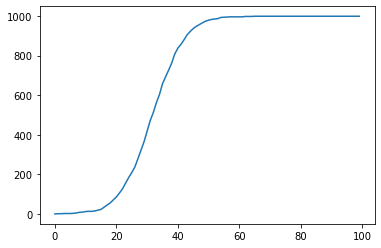

In [102]:
#gather data
tick_numbers = []
infected_at_tick = []

#watch chaos unfold
for i in range(100):
    g.tick()
    tick_numbers.append(i)
    infected_at_tick.append(g.amount_of_infected)    

#plot the sucker
plt.plot(tick_numbers, infected_at_tick)